In [ ]:
#'''
#! mkdir SPADE-unet-gan
#! mkdir SPADE-unet-gan/src
#! mkdir SPADE-unet-gan/src/model
! git clone https://github.com/AndreyYashkin/SPADE-gan.git
! pip install -Uqq fastai

from google.colab import drive
drive.mount('/content/drive/')
! cp /content/drive/MyDrive/archive.zip  archive.zip

! mkdir SPADE-unet-gan/data
! rm -rf 'SPADE-unet-gan/data/ADE20K Outdoors'
! unzip archive.zip -d 'SPADE-unet-gan/data/ADE20K Outdoors'
#'''

In [1]:
! nvidia-smi # Tesla P100-PCIE

Mon May 31 14:11:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%cd SPADE-gan

In [2]:
import os
from fastai.vision.all import *

from src.callblocks import *
from src.cgan import *
from src.data import *
from src.show import *

from src.model.discriminator import *
from src.model.gan_loss import gen_hinge_loss, dis_hinge_loss
from src.model.generator import Generator, GenerationSize

In [3]:
def img_to_mask_path(path):
  path = str(path).replace('ADE20K Outdoors/images', 'ADE20K Outdoors/annotations')
  path = path[:-4] + '.png'
  return Path(path)

In [4]:
bs = 30 #32 #30
im_size = GenerationSize.s_128x128
nz = 256
gen_norm = nn.BatchNorm2d
dis_norm = nn.BatchNorm2d
#epoches = 100 #20#0
lr = 2e-4

class_n = 150 + 1 # +1 is an unknown class
ngf = 64
embedding_dim = 128
ndf = 64
dis_layers = 4

save_to = '/content/drive/MyDrive/SPADE/2'

In [5]:
TensorMask._show_args['cmap'] = 'hsv'

In [6]:
path = 'data/ADE20K Outdoors/images'
batch_tfms = [ToOneHotTransform(class_n), Normalize.from_stats(*gan_stats)]
dls = SpadeDataLoaders.from_mask_path_func(path, img_to_mask_path, nz, bs=bs, item_tfms=Resize(im_size), batch_tfms=batch_tfms, seed=42)

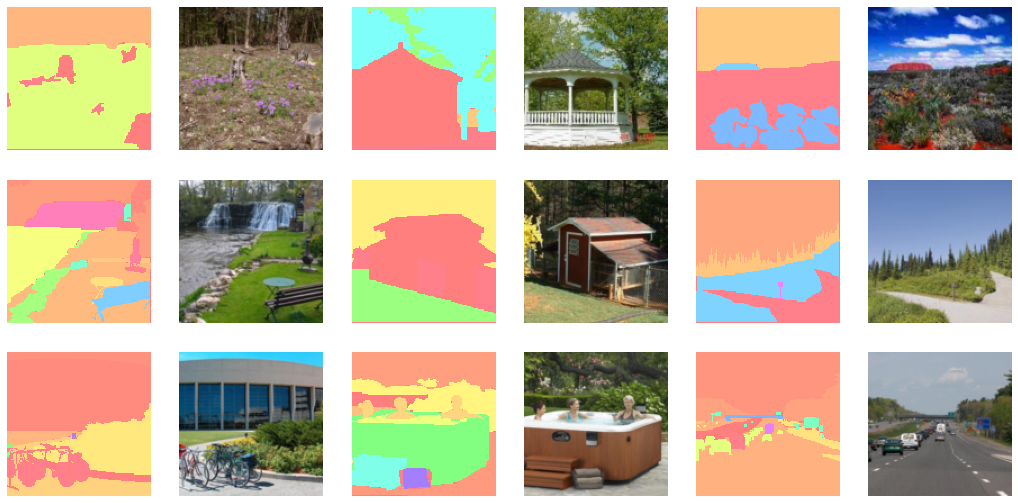

In [ ]:
dls.show_batch(max_n=9)

In [7]:
max_n = 24
test_batch = list(dls.one_batch())
for i in range(len(test_batch)):
  test_batch[i] = test_batch[i][:max_n]

In [ ]:
#for i in range(test_batch[1].shape[0]):
#  torch.argmax(test_batch[1][i], dim=0).show()

In [9]:
record = 'record8'
cbs = GANEvolutionRecorder(storege_path=os.path.join(save_to, record), test_batch=test_batch, plot_fn=plot_record_fn)

In [10]:
gen = Generator(im_size, nz, ngf, class_n, embedding_dim=embedding_dim, norm_type=gen_norm)
#dis = Discriminator(ndf, dis_layers, class_n)
dis_arch = partial(Discriminator, ndf, dis_layers, class_n, norm_type=dis_norm)
dis = MultiScaleDiscriminator(dis_arch, 2)
switcher = FixedGANSwitcher(n_crit=1, n_gen=1)

opt_func = partial(Adam, mom=0.5, sqr_mom=0.999)
learn = GANLearner_modified(dls, gen, dis, gen_hinge_loss, dis_hinge_loss, lr=lr, prepare_crit_batch_func=add_mask, switcher=switcher, cbs=cbs, opt_func=opt_func)

learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False

In [11]:
dis

MultiScaleDiscriminator(
  (dis_l): ModuleList(
    (0): Discriminator(
      (body): Sequential(
        (0): Conv2d(154, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        (1): LeakyReLU(negative_slope=0.2)
        (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (4): LeakyReLU(negative_slope=0.2, inplace=True)
        (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (7): LeakyReLU(negative_slope=0.2, inplace=True)
        (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
        (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (10): LeakyReLU(negative_slope=0.2, inplace=True)
        (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))


In [ ]:
#gen

In [ ]:
learn.fit(100, lr)

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,gen_loss,crit_loss,time
0,0.913707,-0.097597,2.016385,01:53
1,0.976788,-0.054921,1.986142,01:45
2,1.004746,0.006098,1.987301,01:45
3,0.933549,-0.044928,1.929961,01:45
4,0.896409,-0.034014,1.783145,01:46
5,0.943978,-0.047228,1.859280,01:46
6,1.006801,0.004049,1.980096,01:45
7,1.006109,0.089967,1.923098,01:45
8,0.894577,-0.029728,1.855573,01:46
9,0.909867,-0.051724,1.795589,01:46


/usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


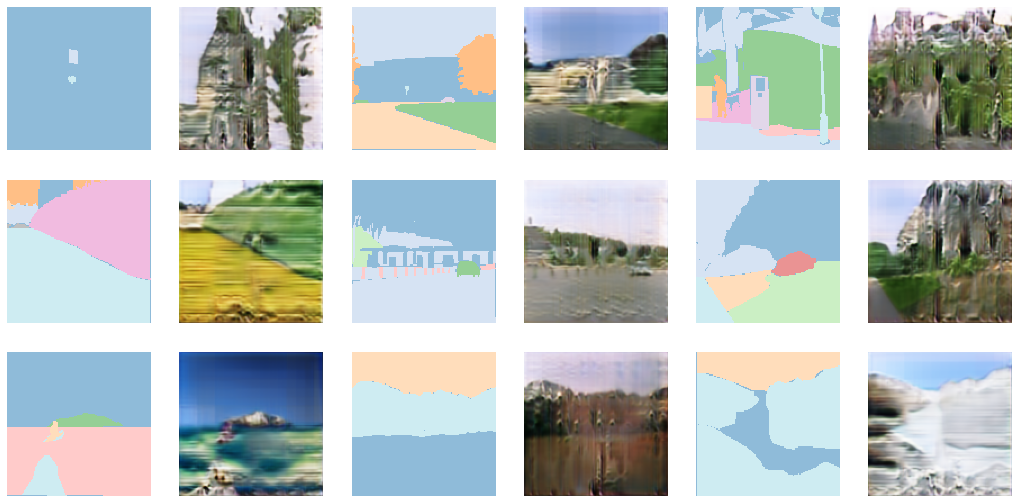

In [ ]:
learn.show_results(max_n=9, ds_idx=0)

In [ ]:
learn.save(os.path.join(save_to, '100 epoch'), with_opt=True)

Path('/content/drive/MyDrive/SPADE/2/100 epoch.pth')

In [ ]:
learn.load(os.path.join(save_to, '100 epoch'))

In [ ]:
learn.fit(100, lr)

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,gen_loss,crit_loss,time
0,0.254071,-0.788807,1.257333,01:53
1,0.339584,-0.705449,1.518453,01:45
2,0.298266,-0.822988,1.260586,01:45
3,0.583131,-0.675332,1.676535,01:45
4,0.350383,-0.633474,1.465250,01:45
5,0.620909,-0.558256,1.679504,01:45
6,0.282140,-0.827306,1.466084,01:45
7,0.591749,-0.522857,1.665796,01:45
8,0.447191,-0.588909,1.574939,01:45
9,0.383425,-0.640574,1.591308,01:45


/usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
learn.save(os.path.join(save_to, '200 epoch'), with_opt=True)

Path('/content/drive/MyDrive/SPADE/2/200 epoch.pth')

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


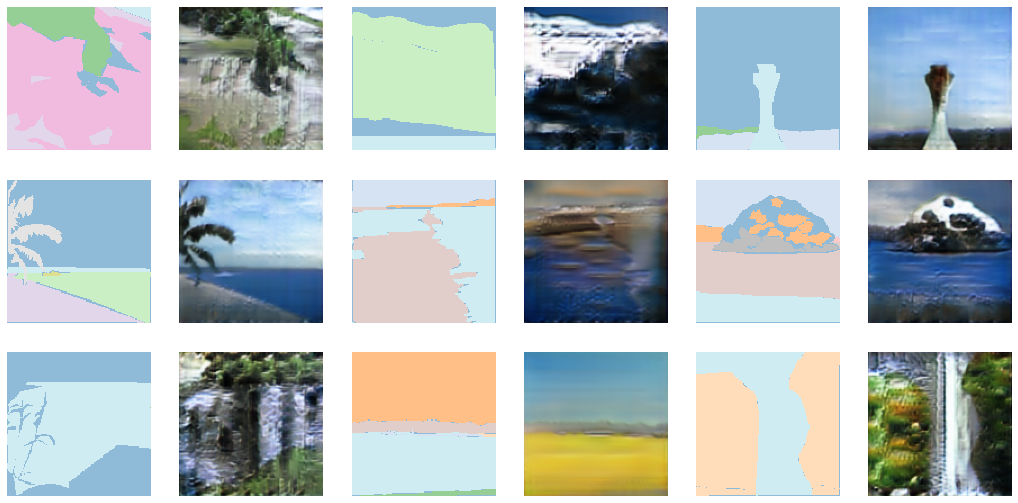

In [ ]:
learn.show_results(max_n=9, ds_idx=0)

In [ ]:
learn.load(os.path.join(save_to, '200 epoch'))

In [ ]:
#sched = {'lr': SchedExp(start=lr, end=lr/20)}
sched = {'lr': SchedExpPart(start=lr, end=lr/20, start_part=0.0, end_part=0.5)}
learn.fit(100, cbs=ParamScheduler(sched))

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,gen_loss,crit_loss,time
0,0.641142,-0.398100,1.728335,02:01
1,0.630838,-0.420736,1.773974,01:53
2,0.386839,-0.494786,1.630269,01:53
3,0.668951,-0.507950,1.692293,01:53
4,0.628654,-0.278445,1.650437,01:53
5,0.641475,-0.427921,1.678519,01:54
6,0.696523,-0.328585,1.762287,01:53
7,0.546035,-0.465026,1.674912,01:54
8,0.701248,-0.433341,1.664731,01:53
9,0.481704,-0.467735,1.431052,01:53


/usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
#learn.save(os.path.join(save_to, '300 epoch'), with_opt=True)

In [ ]:
learn.load(os.path.join(save_to, '300 epoch'))

In [ ]:
sched = {'lr': SchedExpPart(start=lr, end=lr/20, start_part=0.5, end_part=0.75)}
learn.fit(50, cbs=ParamScheduler(sched))

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,gen_loss,crit_loss,time
0,0.801476,0.066949,1.634003,03:50
1,0.648597,-0.138228,1.518577,03:41
2,0.689644,-0.125576,1.536593,03:40
3,0.698489,-0.110029,1.554932,03:40
4,0.751337,-0.073936,1.533656,03:41
5,0.733745,-0.127101,1.545913,03:40
6,0.663242,-0.132686,1.520921,03:40
7,0.826303,-0.017152,1.628673,03:41
8,0.781182,0.009729,1.569365,03:40
9,0.862810,0.026913,1.590926,03:41


/usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
#learn.save(os.path.join(save_to, '350 epoch'), with_opt=True)

Path('/content/drive/MyDrive/SPADE/2/350 epoch.pth')

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


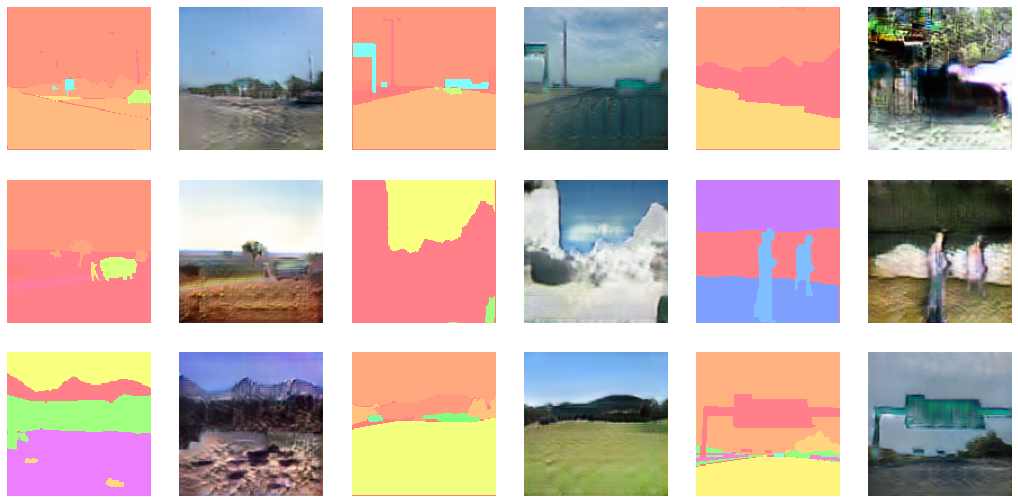

In [ ]:
learn.show_results(max_n=9, ds_idx=0)

In [ ]:
learn.load(os.path.join(save_to, '350 epoch'))

In [ ]:
sched = {'lr': SchedExpPart(start=lr, end=lr/20, start_part=0.75, end_part=1.0)}
learn.fit(50, cbs=ParamScheduler(sched))

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,gen_loss,crit_loss,time
0,0.815480,0.111907,1.501575,02:00
1,0.832661,0.103901,1.516681,01:53
2,0.774432,0.101426,1.461555,01:53
3,0.872036,0.199044,1.517227,01:53
4,0.797549,0.103366,1.493497,01:53
5,0.749767,0.036990,1.510575,01:53
6,0.818187,0.161811,1.526149,01:53
7,0.824228,0.097090,1.570436,01:53
8,0.845765,0.102492,1.502167,01:53
9,0.805765,0.039795,1.517037,01:53


/usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
learn.save(os.path.join(save_to, '400 epoch'), with_opt=True)

Path('/content/drive/MyDrive/SPADE/2/400 epoch.pth')

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


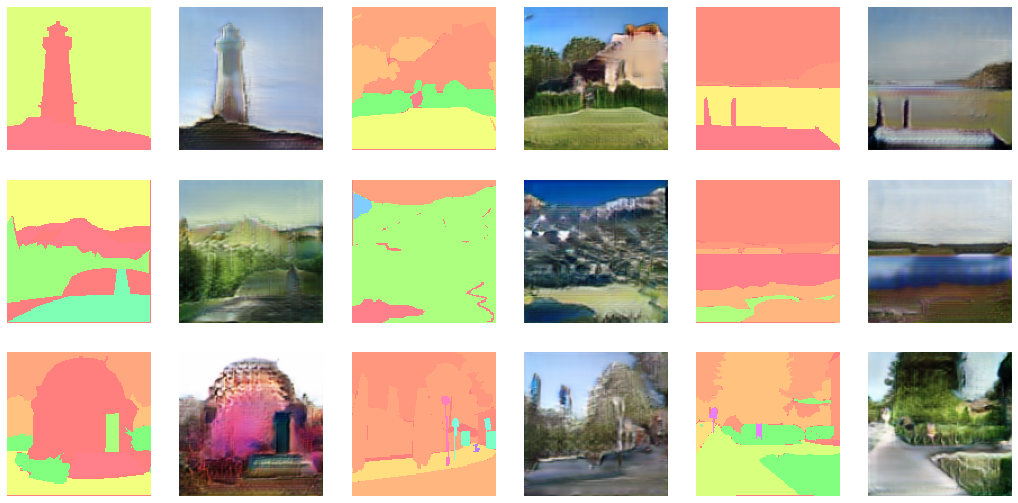

In [ ]:
learn.show_results(max_n=9, ds_idx=0)

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


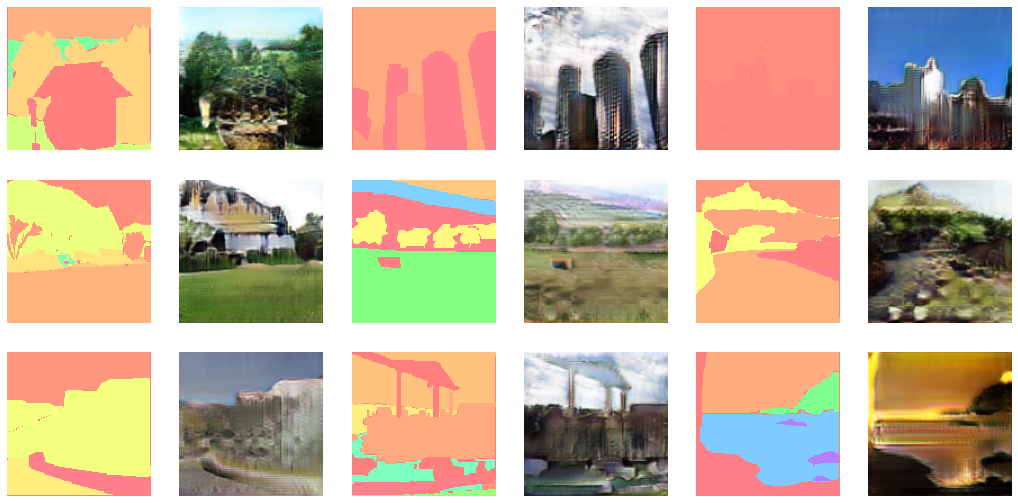

In [ ]:
learn.show_results(max_n=9, ds_idx=0)

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


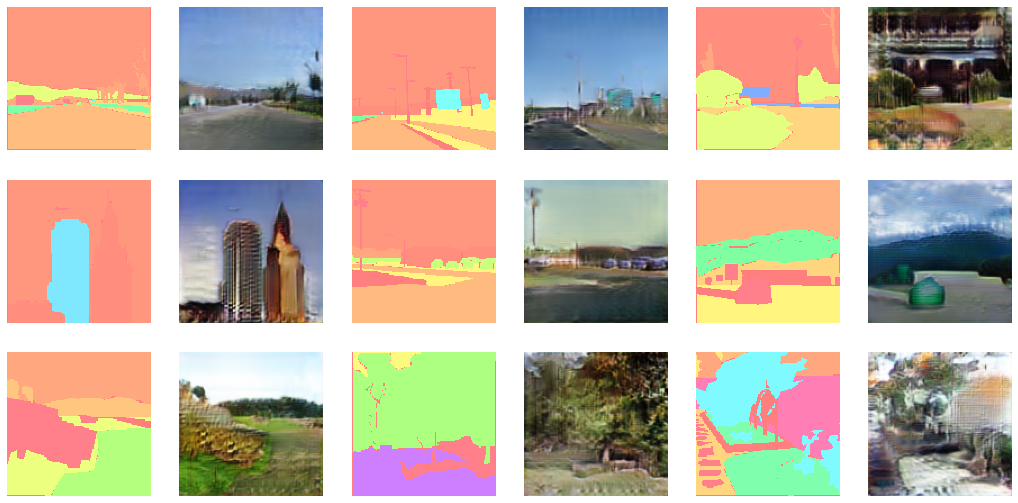

In [ ]:
learn.show_results(max_n=9, ds_idx=0)